# Import Modules

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from numpy import asarray
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report

# %tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import * 

import keras
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import callbacks

np.random.seed(1)
from tensorflow.random import set_seed
set_seed(2)

Using TensorFlow backend.


In [ ]:
from tensorflow.python.client import device_lib
if __name__ == "__main__":
    print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4457215741877915699
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4093333140861285085
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6054875089965224037
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11150726272
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13544262041226930133
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


# Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/SemEval_2020

/content/drive/My Drive/SemEval_2020


## *Import processed data*

In [ ]:
# Import pre-processed image data
import pickle 

data = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/NewData_6988.pickle", "rb"))
X = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/NewTrainX_6988.pickle", "rb")) #import preprocessed 128*128 data


data_trial = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/TrialData_910.pickle", "rb"))
X_trial = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/TrialX_910.pickle", "rb"))

data_test = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/TestData_1877.pickle", "rb"))
X_test = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/TestX_1877.pickle", "rb"))

In [ ]:
data.describe()

,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment,taskA
count,6988,6988,6988,6988,6988,6988,6988,6988,6988
unique,6988,6643,6935,4,4,4,2,5,3
top,image_5564.jpg,,,funny,general,not_offensive,not_motivational,positive,positive
freq,1,160,10,2450,3505,2711,4522,3124,4156


In [ ]:
data.text_corrected.value_counts()

                                                                                                                                                        10
Bill is on the internet. Bill sees something that offends him. Bill moves on. Bill is smart. Be like Bill.                                               3
BUT I'M SUCH A NICE GUY memegenerator.net                                                                                                                3
FEMINISM. YOU KEEP USING THAT WORD I DO NOT THINK IT MEANS WHAT YOU THINK IT MEANS memegenerator.net                                                     3
The Titanic sank with approximately 3000 pounds of garlic bread on board' Me:                                                                            2
                                                                                                                                                        ..
IF YOU COULD STOP POSTING "ENTRY LEVEL" POSITIONS THAT REQUIRE 3-5 YEA

In [ ]:
data.text_corrected.value_counts()

In [ ]:
width, height, channels = X.shape[1:]
print(X.shape)
print(X_trial.shape)
print(X_test.shape)

X = X/255
X_trial = X_trial/255
X_test = X_test/255

(6988, 128, 128, 3)
(910, 128, 128, 3)
(1877, 128, 128, 3)


In [ ]:
data = data.reset_index(drop=True)
Y_3 = np.array(data['overall_sentiment'].replace('very_positive','positive').replace('very_negative','negative'))
data['taskA'] = Y_3
print(data['taskA'].value_counts())

positive    4156
neutral     2201
negative     631
Name: taskA, dtype: int64


In [ ]:
data['taskA'].factorize(sort=True)

(array([2, 2, 2, ..., 2, 2, 2]),
 Index(['negative', 'neutral', 'positive'], dtype='object'))

In [ ]:
np.unique(Y_3)

array(['negative', 'neutral', 'positive'], dtype=object)

In [ ]:
Y = to_categorical(data['taskA'].factorize(sort=True)[0])

# use classes weights to handle data imbalance
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(Y_3),Y_3)
class_weights = {i : class_weights[i] for i in range(3)}
class_weights

{0: 3.6914949815108296, 1: 1.058306830228684, 2: 0.560474815527751}

In [ ]:
data_trial['taskA'].value_counts()

positive    560
neutral     279
negative     71
Name: taskA, dtype: int64

In [ ]:
data_trial['taskA'].factorize(sort=True)[1]

Index(['negative', 'neutral', 'positive'], dtype='object')

In [ ]:
Y_trial = to_categorical(data_trial['taskA'].factorize(sort=True)[0])

# Modelling

## Text Data
可以尝试word2vec

In [ ]:
def encodeText(orig_text,max_len=0):
  t = Tokenizer()
  X_text = [str(i) for i in orig_text]
  t.fit_on_texts(X_text)
  vocab_size = len(t.word_index) + 1
  encoded_train = t.texts_to_sequences(X_text)
  max_length = max(list(map(lambda x: len(x), encoded_train))) if max_len==0 else max_len
  padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
  return padded_train, vocab_size, max_length

In [ ]:
X_text, vocab_size, max_length = encodeText(data['text_corrected'])
print(vocab_size, max_length) 

13367 192


In [ ]:
X_text_trial, vocab_size_trial, max_length_trial = encodeText(data_trial['corrected_text'],192)
print(vocab_size_trial, max_length_trial) 

1569 192


In [ ]:
X_text_test, vocab_size_test, max_length_test = encodeText(data_test['corrected_text'],192)
print(vocab_size_test, max_length_test) 

6042 192


### Data Sampling

In [ ]:
data_minorclass1=(data.loc[data['overall_sentiment'] == 'negative'])
data_minorclass2=(data.loc[data['overall_sentiment'] == 'neutral'])
data_majorityclass=(data.loc[data['overall_sentiment'] == 'positive'])


X1=data.drop(['overall_sentiment'], axis=1)
Xmin1=data_minorclass1.drop(['overall_sentiment'], axis=1)
Xmin2=data_minorclass2.drop(['overall_sentiment'], axis=1)
Xa=data_minorclass1.drop(['overall_sentiment'], axis=1).values
Xb=data_minorclass2.drop(['overall_sentiment'], axis=1).values
Xmaj=data_majorityclass.drop(['overall_sentiment'], axis=1)
ymin1=data_minorclass1.overall_sentiment
ymin2=data_minorclass2.overall_sentiment
ymaj=data_majorityclass.overall_sentiment

In [ ]:
padded_min1, vocab_size, max_length = encodeText(Xmin1['text_corrected'])

In [ ]:
padded_min2, vocab_size, max_length = encodeText(Xmin2['text_corrected'])

In [ ]:
padded_maj, vocab_size, max_length = encodeText(Xmaj['text_corrected'])

In [ ]:
Xa=padded_min1
Xb=padded_min2
Xmaj=padded_maj

In [ ]:
ymin1=data_minorclass1.overall_sentiment
ymin2=data_minorclass2.overall_sentiment
ymaj=data_majorityclass.overall_sentiment

In [ ]:
# import KMeans
from sklearn.cluster import KMeans
# create kmeans object
nc1=int(len(Xmaj)-len(Xa)-(len(Xmaj)-len(Xa))*0.3)
nc1
kmeans1 = KMeans(n_clusters=nc1)

In [ ]:
kmeans1.fit(Xmaj)
# print location of clusters learned by kmeans object
print(kmeans1.cluster_centers_)

[[ 8.90833333e+01  2.02916667e+02  2.14083333e+02 ...  1.38777878e-17
   0.00000000e+00 -4.44089210e-16]
 [ 2.21058824e+02  2.74176471e+02  1.65411765e+02 ...  1.38777878e-17
   0.00000000e+00 -4.44089210e-16]
 [ 1.48026667e+03  1.48946667e+03  8.43333333e+01 ...  1.38777878e-17
   0.00000000e+00 -4.44089210e-16]
 ...
 [ 1.36200000e+03  7.65000000e+02  2.26900000e+03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+01  1.22000000e+02  3.48000000e+02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 5.15000000e+01  1.57250000e+02  2.06250000e+02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [ ]:
Xmaj1=kmeans1.cluster_centers_
# save new clusters for chart
y_km1 = kmeans1.fit_predict(Xmaj1)

In [ ]:
Xmaj1= pd.DataFrame(data=Xmaj1)

In [ ]:
# import KMeans
from sklearn.cluster import KMeans
# create kmeans object
nc2=int(len(Xmaj)-len(Xb)-(len(Xmaj)-len(Xb))*0.05)
nc2
kmeans2 = KMeans(n_clusters=nc2)

In [ ]:
kmeans2.fit(Xmaj)
# print location of clusters learned by kmeans object
print(kmeans2.cluster_centers_)

[[ 4.18600000e+03  4.00000000e+00  1.09000000e+02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.85384615e+01  1.29538462e+02  3.33730769e+02 ...  2.77555756e-17
  -4.16333634e-17 -4.44089210e-16]
 [ 3.18833333e+02  7.08666667e+02  4.62500000e+02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 1.00000000e+01  1.60000000e+01  1.76900000e+03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.87142857e+01  5.23428571e+02  2.41842857e+03 ...  0.00000000e+00
   0.00000000e+00 -2.22044605e-16]
 [ 5.00000000e+00  3.90000000e+01  1.30000000e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [ ]:
Xmaj2=kmeans2.cluster_centers_
# save new clusters for chart
y_km2 = kmeans2.fit_predict(Xmaj2)

In [ ]:
Xmaj2= pd.DataFrame(data=Xmaj2)

In [ ]:
#GMM
from sklearn.mixture import GaussianMixture as GMM
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 8
from sklearn.mixture import GaussianMixture
X_train_min1, X_test_min1, y_train_min1, y_test_min1 = train_test_split(Xa, ymin1, test_size=0.2, random_state=0)
X_train_min2, X_test_min2, y_train_min2, y_test_min2 = train_test_split(Xb, ymin2, test_size=0.2, random_state=0)
X_train_maj, X_test_maj, y_train_maj, y_test_maj = train_test_split(Xmaj, ymaj, test_size=0.2, random_state=0)
#X_train_maj1, X_test_maj1, y_train_maj1, y_test_maj1 = train_test_split(Xmaj2, ymaj, test_size=0.2, random_state=0)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
print(X_train_min1.shape)
Xmin1 = pca.fit_transform(X_train_min1)
print(Xmin1.shape)

(384, 59)
(384, 34)


In [ ]:
X_train_min1.shape,Xmaj1.shape

((384, 59), (1850, 192))

In [ ]:
gmm = GaussianMixture(2, covariance_type='full', random_state=0)
gmm.fit(Xmin1)
# print(gmm.converged_)
# print (gmm.means_)
# print (gmm.covariances_)
datanew1 = gmm.sample(len(Xmaj1)-len(X_train_min1)) #use cluster center instead X_train_maj
new_x1, x2 = datanew1
print(new_x1)
new_X1 = pca.inverse_transform(new_x1)

[[ 1.07041359 -1.77940169  0.2701349  ...  0.63374548 -0.95060515
   0.35624553]
 [ 1.19946039 -1.01763777  0.90330361 ...  0.39989439 -0.08615962
  -0.11545953]
 [ 1.12377821 -1.70853941  0.45467968 ...  0.58552967 -0.73368884
   0.26263064]
 ...
 [ 1.31450506  0.44864797 -0.76417188 ...  0.45471063  0.56666198
   0.53447911]
 [-0.06144113 -1.1482893   0.47188546 ... -0.47451349 -1.12253524
   0.47168792]
 [-0.74919798 -1.90920431  0.78091981 ... -0.88574918  0.93152379
  -0.69898682]]


In [ ]:
X_train_min= pca.inverse_transform(Xmin1)
os_data_X1 = pd.DataFrame(data=new_X1)
X_train_min = pd.DataFrame(data=X_train_min)
X_osmin1=X_train_min.merge(os_data_X1, how='outer')
print(X_osmin1.shape)


(1850, 59)


In [ ]:
len(y_train_maj)

2499

In [ ]:
len(Xmaj1)

1850

In [ ]:
new_Ymaj=[]
for i in range(len(Xmaj1)):
#for i in y_train_maj:
    y='positive'
    new_Ymaj.append(y)



os_data_y= pd.DataFrame(data=new_Ymaj,columns=['overall_sentiment'])
y_train_maj1= pd.DataFrame(data=new_Ymaj,columns=['overall_sentiment'])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
Xmin2 = pca.fit_transform(X_train_min2)
X_train_min2.shape,Xmin2.shape


((1760, 72), (1760, 33))

In [ ]:
gmm2 = GaussianMixture(2, covariance_type='full', random_state=0)
gmm2.fit(Xmin2)
# print(gmm2.converged_)
# print (gmm2.means_)
# print (gmm2.covariances_)
datanew2 = gmm2.sample(len(X_train_min2)-len(Xmaj2))
new_x2, x3 = datanew2
#print(new_x2)
new_X2 = pca.inverse_transform(new_x2)
print(new_X2.shape)

(884, 72)


In [ ]:
len(Xmaj2)

876

In [ ]:
len(X_train_min2)

1760

In [ ]:
X_train_min2= pca.inverse_transform(Xmin2)
os_data_X2 = pd.DataFrame(data=new_X2)
X_train_min2= pd.DataFrame(data=X_train_min2)
X_osmin2=X_train_min2.merge(os_data_X2, how='outer')
print(X_osmin2.shape)


(2644, 72)


In [ ]:
X_osmin=X_osmin1.merge(X_osmin2, how='outer')

In [ ]:
Xmaj1= pd.DataFrame(data=X_train_maj)

In [ ]:
print('min,max in minor class 1:',X_osmin1.values.min(),X_osmin1.values.max())
print('min,max in minor class 2:',X_osmin2.values.min(),X_osmin2.values.max())
print('min,max in major class:',X_train_maj.min(),X_train_maj.max())

min,max in minor class 1: -2169.2151878106547 3362.429373008541
min,max in minor class 2: -4377.53335943761 7816.957798099669
min,max in major class: 0 8236


In [ ]:
X_os=X_osmin.merge(Xmaj1, how='outer')
X_os.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


(6993, 192)

In [ ]:
new_Ymin1=[]
for i in range(len(X_osmin1)):
    y='negative'
    new_Ymin1.append(y)

os_ymin1= pd.DataFrame(data=new_Ymin1,columns=['overall_sentiment'])

In [ ]:
os_ymin1.shape

(1850, 1)

In [ ]:
new_Ymin2=[]
for i in range(len(X_osmin2)):
    y='neutral'
    new_Ymin2.append(y)



os_ymin2= pd.DataFrame(data=new_Ymin2,columns=['overall_sentiment'])

In [ ]:
os_ymin2.shape

(2644, 1)

In [ ]:
y_nn=os_ymin1.merge(os_ymin2,how='outer')

In [ ]:
y_os=y_nn.merge(os_data_y,how='outer')

In [ ]:
num_class = 3
Ys=pd.get_dummies(y_os)

In [ ]:
y_test_maj= pd.DataFrame(data=y_test_maj,columns=['overall_sentiment'])
y_test_min1= pd.DataFrame(data=y_test_min1,columns=['overall_sentiment'])
y_test_min2= pd.DataFrame(data=y_test_min2,columns=['overall_sentiment'])
y_test_nn=y_test_min1.merge(y_test_min2,how='outer')
y_test_total=y_test_nn.merge(y_test_maj,how='outer')

X_test_min1= pd.DataFrame(data=X_test_min1)
X_test_min2= pd.DataFrame(data=X_test_min2)
X_test_maj= pd.DataFrame(data=X_test_maj)
X_test_Val1=X_test_min1.merge(X_test_min2,how='outer')
X_test_Val_t=X_test_Val1.merge(X_test_maj,how='outer')

In [ ]:
y_test_total1=pd.get_dummies(y_test_total)

In [ ]:
Y_3=pd.get_dummies(Y_3)

In [ ]:
Y_3.shape

(6988, 3)

In [ ]:
X_os.shape, Ys.shape

((6993, 192), (6344, 3))

In [ ]:
y_test_total.shape, X_test_Val_t.shape

((1162, 1), (1162, 192))

Split data into 80% training set and 20% test set using stratified sampling

In [ ]:
# Train-test Split
np.random.RandomState(0)
trainX, testX, trainY, testY = train_test_split(padded_train, Y, test_size=0.2, random_state=0,stratify=Y)
# summarize dataset shape
print('Train', trainX.shape, trainY.shape)
print('Test', (testX.shape, testY.shape))

# summarize pixel values
print('Train', trainX.min(), trainX.max(), trainX.mean(), trainX.std())
print('Test', testX.min(), testX.max(), testX.mean(), testX.std())

Train (5590, 192) (5590, 3)
Test ((1398, 192), (1398, 3))
Train 0 13365 98.20806220184853 804.1007522101102
Test 0 13375 103.16041517644254 829.3045567817323


### Data sampling stage 1

In [ ]:
data_minorclass1=(data.loc[data['overall_sentiment'] == 'negative'])
data_minorclass2=(data.loc[data['overall_sentiment'] == 'neutral'])
data_majorityclass=(data.loc[data['overall_sentiment'] == 'positive'])


X1=data.drop(['overall_sentiment'], axis=1)
Xmin1=data_minorclass1.drop(['overall_sentiment'], axis=1)
Xmin2=data_minorclass2.drop(['overall_sentiment'], axis=1)
Xa=data_minorclass1.drop(['overall_sentiment'], axis=1)
Xb=data_minorclass2.drop(['overall_sentiment'], axis=1)
Xmaj=data_majorityclass.drop(['overall_sentiment'], axis=1)
ymin1=data_minorclass1.overall_sentiment
ymin2=data_minorclass2.overall_sentiment
ymaj=data_majorityclass.overall_sentiment

In [ ]:
padded_min1, vocab_size_min1, max_length_min1 = encodeText(Xmin1['text_corrected'])

In [ ]:
padded_min2, vocab_size_min2, max_length_min2 = encodeText(Xmin2['text_corrected'])

In [ ]:
padded_maj, vocab_size_maj, max_length_maj = encodeText(Xmaj['text_corrected'])

In [ ]:
# get text vector data
Xa=padded_min1
Xb=padded_min2
Xmaj=padded_maj

In [ ]:
# target value for each class
ymin1=data_minorclass1.overall_sentiment
ymin2=data_minorclass2.overall_sentiment
ymaj=data_majorityclass.overall_sentiment

In [ ]:
#GMM
from sklearn.mixture import GaussianMixture as GMM
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 8
from sklearn.mixture import GaussianMixture

#train-test split for each class
X_train_min1, X_test_min1, y_train_min1, y_test_min1 = train_test_split(Xa, ymin1, test_size=0.2, random_state=0)
X_train_min2, X_test_min2, y_train_min2, y_test_min2 = train_test_split(Xb, ymin2, test_size=0.2, random_state=0)
X_train_maj, X_test_maj, y_train_maj, y_test_maj = train_test_split(Xmaj, ymaj, test_size=0.2, random_state=0)


In [ ]:
# dimensions reduction by PCA
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
print(X_train_min1.shape)
Xmin1 = pca.fit_transform(X_train_min1)
print(Xmin1.shape)

(384, 59)
(384, 34)


In [ ]:
gmm = GaussianMixture(2, covariance_type='full', random_state=0)
gmm.fit(Xmin1)
# print(gmm.converged_)
# print (gmm.means_)
# print (gmm.covariances_)

#upsampling
datanew1 = gmm.sample(len(X_train_maj)-len(X_train_min1)) #new data
new_x1, x2 = datanew1
print(new_x1.shape)

# inverse PCA for new data
new_X1 = pca.inverse_transform(new_x1)
print(new_X1.shape)



(2115, 34)
(2115, 59)


In [ ]:
#inverse PAC for orignal training set
X_train_min= pca.inverse_transform(Xmin1)

os_data_X1 = pd.DataFrame(data=new_X1)
X_train_min = pd.DataFrame(data=X_train_min)

#merve original training set with new sampling data
X_osmin1=X_train_min.merge(os_data_X1, how='outer')
print(X_osmin1.shape)

(2499, 59)


In [ ]:
len(y_train_maj)

2499

In [ ]:
#Build the target value with the same length as the major class
new_Ymaj=[]
for i in y_train_maj:
    y='positive'
    new_Ymaj.append(y)

os_data_y= pd.DataFrame(data=new_Ymaj,columns=['overall_sentiment'])
y_train_maj1= pd.DataFrame(data=new_Ymaj,columns=['overall_sentiment'])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
Xmin2 = pca.fit_transform(X_train_min2)
X_train_min2.shape,Xmin2.shape

((1760, 72), (1760, 37))

In [ ]:
gmm2 = GaussianMixture(2, covariance_type='full', random_state=0)
gmm2.fit(Xmin2)
# print(gmm2.converged_)
# print (gmm2.means_)
# print (gmm2.covariances_)
datanew2 = gmm2.sample(len(X_train_maj)-len(X_train_min2))
new_x2, x3 = datanew2
#print(new_x2)
new_X2 = pca.inverse_transform(new_x2)
print(new_X2.shape)

(739, 72)


In [ ]:
X_train_min2= pca.inverse_transform(Xmin2)
os_data_X2 = pd.DataFrame(data=new_X2)
X_train_min2= pd.DataFrame(data=X_train_min2)
X_osmin2=X_train_min2.merge(os_data_X2, how='outer')
print(X_osmin2.shape)

(2499, 72)


In [ ]:
X_osmin=X_osmin1.merge(X_osmin2, how='outer') #merge data will keep the max length, and leave NaN data

In [ ]:
X_osmin.iloc[:,62:]

,62,63,64,65,66,67,68,69,70,71
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
4993,0.375217,0.006469,7.006198,2.361276,0.025877,40.788625,0.064693,0.006469,40.795094,6.119911
4994,-0.457378,-0.007886,-8.540349,-2.878326,-0.031543,-49.720129,-0.078858,-0.007886,-49.728015,-7.459991
4995,3.531824,0.060894,65.947682,22.226135,0.243574,383.933643,0.608935,0.060894,383.994536,57.605270
4996,-0.145089,-0.002502,-2.709162,-0.913060,-0.010006,-15.772177,-0.025015,-0.002502,-15.774678,-2.366452


In [ ]:
Xmaj1= pd.DataFrame(data=X_train_maj)

In [ ]:
print('min,max in minor class 1:',X_osmin1.values.min(),X_osmin1.values.max())
print('min,max in minor class 2:',X_osmin2.values.min(),X_osmin2.values.max())
print('min,max in major class:',X_train_maj.min(),X_train_maj.max())

min,max in minor class 1: -2169.2151878106547 3362.429373008541
min,max in minor class 2: -4841.183186082956 7231.333694726491
min,max in major class: 0 8236


In [ ]:
X_os=X_osmin.merge(Xmaj1, how='outer')
X_os.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


(7497, 192)

In [ ]:
new_Ymin1=[]
for i in y_train_maj:
    y='negative'
    new_Ymin1.append(y)



os_ymin1= pd.DataFrame(data=new_Ymin1,columns=['overall_sentiment'])




In [ ]:
os_ymin1.shape

(2499, 1)

In [ ]:
new_Ymin2=[]
for i in y_train_maj:
    y='neutral'
    new_Ymin2.append(y)



os_ymin2= pd.DataFrame(data=new_Ymin2,columns=['overall_sentiment'])




In [ ]:
os_ymin2.shape

(2499, 1)

In [ ]:
y_nn=os_ymin1.merge(os_ymin2,how='outer')

In [ ]:
y_os=y_nn.merge(y_train_maj,how='outer')

In [ ]:
num_class = 3
Ys=pd.get_dummies(y_os)


In [ ]:
y_test_maj= pd.DataFrame(data=y_test_maj,columns=['overall_sentiment'])
y_test_min1= pd.DataFrame(data=y_test_min1,columns=['overall_sentiment'])
y_test_min2= pd.DataFrame(data=y_test_min2,columns=['overall_sentiment'])
y_test_nn=y_test_min1.merge(y_test_min2,how='outer')
y_test_total=y_test_nn.merge(y_test_maj,how='outer')

X_test_min1= pd.DataFrame(data=X_test_min1)
X_test_min2= pd.DataFrame(data=X_test_min2)
X_test_maj= pd.DataFrame(data=X_test_maj)
X_test_Val1=X_test_min1.merge(X_test_min2,how='outer')
X_test_Val_t=X_test_Val1.merge(X_test_maj,how='outer')


In [ ]:
y_test_total1=pd.get_dummies(y_test_total)

### Model 0 - Embedding+LSTM

In [ ]:
np.random.seed(1)
set_seed(2)
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Dropout(0.2))

model.add(LSTM(128, return_sequences=True))  #新版本kerus 取消CuDNNLSTM,但是新版本是否还需要activation?
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(3, activation='softmax'))

# opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-6)
model.compile(loss = "categorical_crossentropy",  #sparse_categorical_crossentropy
             optimizer = 'adam',
             metrics = ['accuracy'
            #  ,keras.metrics.Precision(name='precision'),
                  # keras.metrics.Recall(name='recall')
                  ])
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 192, 100)          1336700   
_________________________________________________________________
dropout_33 (Dropout)         (None, 192, 100)          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 192, 128)          117248    
_________________________________________________________________
dropout_34 (Dropout)         (None, 192, 128)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 24576)             0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                1572928   
_________________________________________________________________
dropout_35 (Dropout)         (None, 64)              

In [ ]:
results = model.fit(X_os, Ys, epochs=10, shuffle=True, validation_split=0.2, batch_size=64)

Epoch 1/10
94/94 [==============================] - 7s 71ms/step - loss: 0.0706 - accuracy: 0.9667 - val_loss: 4.4238e-09 - val_accuracy: 1.0000
Epoch 2/10
94/94 [==============================] - 6s 66ms/step - loss: 2.2475e-05 - accuracy: 1.0000 - val_loss: 3.2596e-09 - val_accuracy: 1.0000
Epoch 3/10
94/94 [==============================] - 6s 66ms/step - loss: 2.2673e-05 - accuracy: 1.0000 - val_loss: 7.7610e-10 - val_accuracy: 1.0000
Epoch 4/10
94/94 [==============================] - 6s 65ms/step - loss: 1.1416e-05 - accuracy: 1.0000 - val_loss: 1.1642e-09 - val_accuracy: 1.0000
Epoch 5/10
94/94 [==============================] - 6s 67ms/step - loss: 7.4635e-06 - accuracy: 1.0000 - val_loss: 9.3132e-10 - val_accuracy: 1.0000
Epoch 6/10
94/94 [==============================] - 6s 65ms/step - loss: 9.7935e-06 - accuracy: 1.0000 - val_loss: 3.8805e-10 - val_accuracy: 1.0000
Epoch 7/10
94/94 [==============================] - 6s 65ms/step - loss: 3.0108e-06 - accuracy: 1.0000 - val_l

In [ ]:
model.evaluate(X_text_trial,Y_trial)

29/29 [==============================] - 1s 17ms/step - loss: 37.2887 - accuracy: 0.0780


[37.288719177246094, 0.07802198082208633]

In [ ]:
temp = model.predict(X_text_trial)
temp_pre = [np.argmax(i) for i in temp]
temp_truth = [np.argmax(i) for i in Y_trial]
print(accuracy_score(temp_pre, temp_truth),f1_score(temp_pre, temp_truth, average='macro'))

0.5615384615384615 0.3061148233268107


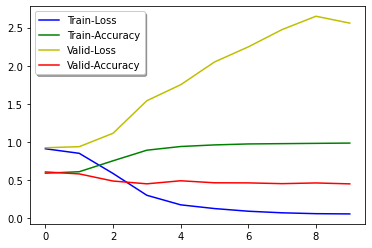

In [ ]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.plot(list(results.history.values())[2],'y',label='Valid-Loss')
plt.plot(list(results.history.values())[3],'r',label='Valid-Accuracy')
plt.legend(loc='upper left', shadow=True)

### Model 0.1 - Embedding+Conv1D  

In [ ]:
np.random.seed(1)
set_seed(2)
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Dropout(0.2))

model.add(Conv1D(250, 3, padding='valid', activation='relu', strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())
# model.add(MaxPooling1D())
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(3, activation='softmax'))
model.compile(loss = "categorical_crossentropy",  #sparse_categorical_crossentropy
             optimizer = 'adam',
             metrics = ['accuracy'])
model.summary()

NameError: ignored

In [ ]:
results = model.fit(X_text, Y, epochs=10, shuffle=True, validation_split=0.2, batch_size=64, class_weight=class_weights)

NameError: ignored

In [ ]:
model.evaluate(X_text_trial,Y_trial)

29/29 [==============================] - 0s 5ms/step - loss: 1.4511 - accuracy: 0.3527


[1.4511420726776123, 0.35274726152420044]

In [ ]:
temp = model.predict(X_text_trial)
temp_pre = [np.argmax(i) for i in temp]
temp_truth = [np.argmax(i) for i in Y_trial]
print(accuracy_score(temp_pre, temp_truth),f1_score(temp_pre, temp_truth, average='macro'))

0.35274725274725277 0.251996628234252


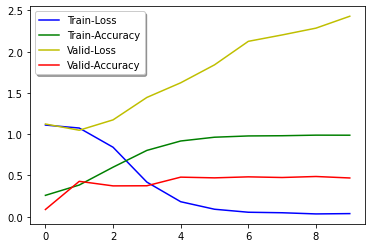

In [ ]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.plot(list(results.history.values())[2],'y',label='Valid-Loss')
plt.plot(list(results.history.values())[3],'r',label='Valid-Accuracy')
plt.legend(loc='upper left', shadow=True)

### Model 0.2 - Embedding+LSTM+Conv1D

In [ ]:
np.random.seed(1)
set_seed(2)
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=max_length))
model.add(Dropout(0.1))
model.add(LSTM(128, return_sequences=True))

model.add(Conv1D(250, 3, padding='valid', activation='relu', strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

model.add(Dense(250, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(3, activation='softmax'))
model.compile(loss = "categorical_crossentropy",  #sparse_categorical_crossentropy
             optimizer = 'adam',
             metrics = ['accuracy'])
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 192, 50)           668350    
_________________________________________________________________
dropout_59 (Dropout)         (None, 192, 50)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 192, 128)          91648     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 190, 250)          96250     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 250)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_60 (Dropout)         (None, 250)             

In [ ]:
results = model.fit(X_text, Y, epochs=10, shuffle=True, validation_split=0.2, batch_size=64, class_weight=class_weights)

Epoch 1/10
88/88 [==============================] - 2s 24ms/step - loss: 1.1087 - accuracy: 0.2522 - val_loss: 1.1136 - val_accuracy: 0.0808
Epoch 2/10
88/88 [==============================] - 2s 20ms/step - loss: 1.1158 - accuracy: 0.2377 - val_loss: 1.1012 - val_accuracy: 0.2439
Epoch 3/10
88/88 [==============================] - 2s 19ms/step - loss: 0.9432 - accuracy: 0.4732 - val_loss: 1.1888 - val_accuracy: 0.3376
Epoch 4/10
88/88 [==============================] - 2s 20ms/step - loss: 0.6406 - accuracy: 0.6921 - val_loss: 1.3333 - val_accuracy: 0.3512
Epoch 5/10
88/88 [==============================] - 2s 20ms/step - loss: 0.4011 - accuracy: 0.8181 - val_loss: 1.5096 - val_accuracy: 0.4514
Epoch 6/10
88/88 [==============================] - 2s 20ms/step - loss: 0.2418 - accuracy: 0.8882 - val_loss: 1.9162 - val_accuracy: 0.4449
Epoch 7/10
88/88 [==============================] - 2s 19ms/step - loss: 0.1690 - accuracy: 0.9277 - val_loss: 2.1804 - val_accuracy: 0.4413
Epoch 8/10
88

In [ ]:
model.evaluate(X_text_trial,Y_trial)

29/29 [==============================] - 0s 5ms/step - loss: 1.7558 - accuracy: 0.3370


[1.755757212638855, 0.3370411694049835]

In [ ]:
temp = model.predict(X_text_trial)
temp_pre = [np.argmax(i) for i in temp]
temp_truth = [np.argmax(i) for i in Y_trial]
print(accuracy_score(temp_pre, temp_truth),f1_score(temp_pre, temp_truth, average='macro'))

0.3370411568409344 0.2348268405227623


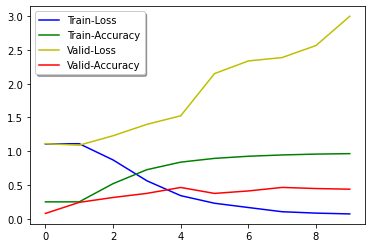

In [ ]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.plot(list(results.history.values())[2],'y',label='Valid-Loss')
plt.plot(list(results.history.values())[3],'r',label='Valid-Accuracy')
plt.legend(loc='upper left', shadow=True)

## Image Data

In [ ]:
class_weights

{0: 3.6914949815108296, 1: 1.058306830228684, 2: 0.560474815527751}

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False
)
datagen.fit(X)

### Model 1 - CIFAR10 CNN 0.5699/0.5943(generator)
Conv-Conv-Maxpool-Dense
https://keras.io/examples/cifar10_cnn/

In [ ]:
# define model
# from keras import regularizers
np.random.seed(1)
set_seed(2)
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform',input_shape=(width, height, channels)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), activation='relu',padding='same', kernel_initializer='he_uniform'))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))

model.add(Flatten())
# model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01)))
# model.add(Dropout(0.2))


model.add(Dense(3, activation='softmax'))
opt = Adam(lr=0.001, decay=1e-6)
# compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 63, 63, 32)        9248      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 28800)            

In [ ]:
es = callbacks.EarlyStopping(monitor='val_acc', mode='max')

# fit model with generator
results = model.fit(X, Y,
         epochs=20,
         batch_size=128,
         shuffle=True,
        validation_split=0.2,
        #  validation_data=(testX,testY),
#          callbacks=[es],
         class_weight=class_weights          
         )
# model.fit_generator(train_iterator, steps_per_epoch=len(train_iterator), epochs=1)

# evaluate model
# _, acc = model.evaluate_generator(test_iterator, steps=len(test_iterator), verbose=0)
# print('Test Accuracy: %.3f' % (acc * 100))

Epoch 1/20
44/44 [==============================] - 11s 241ms/step - loss: 2.8712 - accuracy: 0.3193 - val_loss: 1.1190 - val_accuracy: 0.3011
Epoch 2/20
44/44 [==============================] - 9s 203ms/step - loss: 1.1017 - accuracy: 0.2986 - val_loss: 1.1218 - val_accuracy: 0.2475
Epoch 3/20
44/44 [==============================] - 9s 202ms/step - loss: 1.0652 - accuracy: 0.3564 - val_loss: 1.0794 - val_accuracy: 0.3484
Epoch 4/20
44/44 [==============================] - 9s 203ms/step - loss: 1.0052 - accuracy: 0.4651 - val_loss: 1.1005 - val_accuracy: 0.3562
Epoch 5/20
44/44 [==============================] - 9s 203ms/step - loss: 0.9290 - accuracy: 0.4968 - val_loss: 1.1233 - val_accuracy: 0.3741
Epoch 6/20
44/44 [==============================] - 9s 203ms/step - loss: 0.8512 - accuracy: 0.5587 - val_loss: 1.2184 - val_accuracy: 0.3534
Epoch 7/20
44/44 [==============================] - 9s 203ms/step - loss: 0.7571 - accuracy: 0.5995 - val_loss: 1.1924 - val_accuracy: 0.4213
Epoch

In [ ]:
model.evaluate(X_trial,Y_trial)

29/29 [==============================] - 1s 24ms/step - loss: 1.6337 - accuracy: 0.7703


[1.6337088346481323, 0.7703296542167664]

In [ ]:
temp = model.predict(X_trial)
temp_pre = [np.argmax(i) for i in temp]
temp_truth = [np.argmax(i) for i in Y_trial]
print(accuracy_score(temp_pre, temp_truth),f1_score(temp_pre, temp_truth, average='macro'))

0.7703296703296704 0.6995340886277336


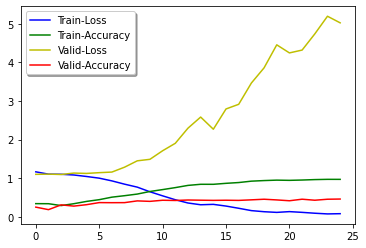

In [ ]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.plot(list(results.history.values())[2],'y',label='Valid-Loss')
plt.plot(list(results.history.values())[3],'r',label='Valid-Accuracy')
plt.legend(loc='upper left', shadow=True)

In [ ]:
results = model.fit_generator(datagen.flow(X, Y, batch_size=32),
                    steps_per_epoch=len(X) / 32, epochs=5,class_weight=class_weights, validation_data=(testX,testY))

Epoch 1/5
219/218 [==============================] - 26s 117ms/step - loss: 1.3448 - accuracy: 0.5933
Epoch 2/5
219/218 [==============================] - 26s 117ms/step - loss: 1.2433 - accuracy: 0.5947
Epoch 3/5
219/218 [==============================] - 26s 117ms/step - loss: 1.2405 - accuracy: 0.5947
Epoch 4/5
219/218 [==============================] - 26s 117ms/step - loss: 1.2437 - accuracy: 0.5947
Epoch 5/5
219/218 [==============================] - 26s 116ms/step - loss: 1.2416 - accuracy: 0.5947


In [ ]:
model.evaluate(testX,testY)

1395/1395 [==============================] - 1s 392us/sample - loss: 0.8908 - acc: 0.5950


[0.8908236489928324, 0.5949821]

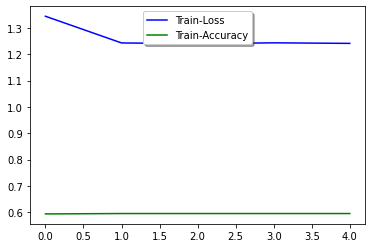

In [ ]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)

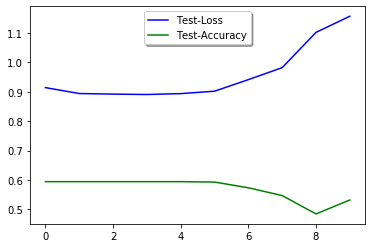

In [ ]:
plt.plot(list(results.history.values())[2],'b',label='Test-Loss')
plt.plot(list(results.history.values())[3],'g',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

### Model 2 (Siyuan) 0.7809
Conv32-Conv64-Conv128-Dense128 (image only)

In [ ]:
# 3 Conv model
np.random.seed(1)
set_seed(2)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',input_shape=(width, height, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 32768)            

In [ ]:
es = callbacks.EarlyStopping(monitor='loss', mode='min')
results = model.fit(X, Y,
         epochs=20,
         batch_size=128,
         shuffle=True,
        validation_split=0.2,
        #  validation_data=(testX,testY),
#          callbacks=[es],
        class_weight=class_weights,
         )

Epoch 1/20
44/44 [==============================] - 7s 158ms/step - loss: 3.7687 - accuracy: 0.2045 - val_loss: 1.1100 - val_accuracy: 0.1109
Epoch 2/20
44/44 [==============================] - 6s 136ms/step - loss: 1.1037 - accuracy: 0.2360 - val_loss: 1.1074 - val_accuracy: 0.1538
Epoch 3/20
44/44 [==============================] - 6s 137ms/step - loss: 1.0894 - accuracy: 0.2784 - val_loss: 1.1115 - val_accuracy: 0.1881
Epoch 4/20
44/44 [==============================] - 6s 137ms/step - loss: 1.0440 - accuracy: 0.3619 - val_loss: 1.0986 - val_accuracy: 0.3233
Epoch 5/20
44/44 [==============================] - 6s 137ms/step - loss: 0.9574 - accuracy: 0.4494 - val_loss: 1.1504 - val_accuracy: 0.3405
Epoch 6/20
44/44 [==============================] - 6s 136ms/step - loss: 0.8363 - accuracy: 0.5295 - val_loss: 1.1854 - val_accuracy: 0.3941
Epoch 7/20
44/44 [==============================] - 6s 137ms/step - loss: 0.7058 - accuracy: 0.6236 - val_loss: 1.2227 - val_accuracy: 0.4263
Epoch 

In [ ]:
model.evaluate(X_trial,Y_trial)

29/29 [==============================] - 0s 16ms/step - loss: 1.4333 - accuracy: 0.7956


[1.4332642555236816, 0.795604407787323]

In [ ]:
temp = model.predict(X_trial)
temp_pre = [np.argmax(i) for i in temp]
temp_truth = [np.argmax(i) for i in Y_trial]
print(accuracy_score(temp_pre, temp_truth),f1_score(temp_pre, temp_truth, average='macro'))

0.7956043956043956 0.7295731329375003


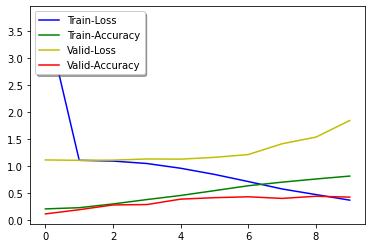

In [ ]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.plot(list(results.history.values())[2],'y',label='Valid-Loss')
plt.plot(list(results.history.values())[3],'r',label='Valid-Accuracy')
plt.legend(loc='upper left', shadow=True)

In [ ]:
results = model.fit_generator(datagen.flow(X, Y, batch_size=64),
                    steps_per_epoch=len(X) / 64, epochs=10,class_weight=class_weights, validation_data=(testX,testY))

### Model 3 - 0.776
Conv32-Maxpool-Conv64-Maxpool-Dense128

In [ ]:
# define model

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(width, height, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(3, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 61504)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [ ]:
es = callbacks.EarlyStopping(monitor='loss', mode='min')
results = model.fit(X, Y,
         epochs=15,
         batch_size=128,
         shuffle=True,
        validation_split=0.2,
        #  validation_data=(testX,testY),
        #  callbacks=[es],
        class_weight=class_weights,
         )

Epoch 1/15
44/44 [==============================] - 6s 127ms/step - loss: 1.9721 - accuracy: 0.4385 - val_loss: 1.0986 - val_accuracy: 0.1903
Epoch 2/15
44/44 [==============================] - 5s 121ms/step - loss: 1.1049 - accuracy: 0.3190 - val_loss: 1.1056 - val_accuracy: 0.1073
Epoch 3/15
44/44 [==============================] - 5s 121ms/step - loss: 1.1018 - accuracy: 0.3562 - val_loss: 1.1059 - val_accuracy: 0.1638
Epoch 4/15
44/44 [==============================] - 5s 121ms/step - loss: 1.0797 - accuracy: 0.3864 - val_loss: 1.1253 - val_accuracy: 0.2904
Epoch 5/15
44/44 [==============================] - 5s 121ms/step - loss: 1.0351 - accuracy: 0.4141 - val_loss: 1.1121 - val_accuracy: 0.2890
Epoch 6/15
44/44 [==============================] - 5s 122ms/step - loss: 0.9502 - accuracy: 0.5057 - val_loss: 1.1680 - val_accuracy: 0.2954
Epoch 7/15
44/44 [==============================] - 5s 122ms/step - loss: 0.8426 - accuracy: 0.5590 - val_loss: 1.2287 - val_accuracy: 0.3040
Epoch 

In [ ]:
model.evaluate(X_trial,Y_trial)

29/29 [==============================] - 0s 13ms/step - loss: 1.1394 - accuracy: 0.7582


[1.139355182647705, 0.7582417726516724]

In [ ]:
temp = model.predict(X_trial)
temp_pre = [np.argmax(i) for i in temp]
temp_truth = [np.argmax(i) for i in Y_trial]
print(accuracy_score(temp_pre, temp_truth),f1_score(temp_pre, temp_truth, average='macro'))

0.7582417582417582 0.6874772798291063


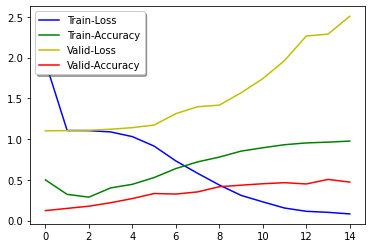

In [ ]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.plot(list(results.history.values())[2],'y',label='Valid-Loss')
plt.plot(list(results.history.values())[3],'r',label='Valid-Accuracy')
plt.legend(loc='upper left', shadow=True)

### Model 5 - CapsNet+Imgage
adapted from keras cifar10 model

In [ ]:
from __future__ import print_function
import tensorflow as tf
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x
# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)

# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)
#     L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + 0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))
#     return L

In [ ]:
class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )

    Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3)) #重新排序维度

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            o = self.activation(tf.keras.backend.batch_dot(c, hat_inputs, [2, 2]))
#             #新版的Keras batch_dot 的结果和原作者expected shape不同
            if i < self.routings - 1:
                b = tf.keras.backend.batch_dot(o, hat_inputs, [2, 3])
#                 b = K.batch_dot(o, hat_inputs, [2, 3])
        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

In [ ]:
batch_size = 64
epochs = 10
num_class = 3

# A common Conv2D model
input_image = Input(shape=(None, None, 3))
x = Conv2D(64, (3, 3), activation='relu')(input_image)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = AveragePooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)


x = Reshape((-1, 128))(x)
capsule = Capsule(num_class, 32, 5, True)(x)
output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)
model = Model(inputs=input_image, outputs=output)

# we use a margin loss
model.compile(loss=margin_loss, optimizer='adam', metrics=['accuracy'])
# model.summary()

ValueError: ignored

In [ ]:
results = model.fit(
        X,
        Y,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
#         validation_data=(testX, testY),
        shuffle=True,
#         class_weight=class_weights
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 5590 samples, validate on 1398 samples
Epoch 1/10





5590/5590 [==============================] - 12s 2ms/step - loss: 0.7470 - acc: 0.5454 - val_loss: 0.7963 - val_acc: 0.6052
Epoch 2/10
5590/5590 [==============================] - 10s 2ms/step - loss: 0.7662 - acc: 0.4070 - val_loss: 0.7928 - val_acc: 0.6052
Epoch 3/10
5590/5590 [==============================] - 10s 2ms/step - loss: 0.7903 - acc: 0.5921 - val_loss: 0.8097 - val_acc: 0.6052
Epoch 4/10
5590/5590 [==============================] - 10s 2ms/step - loss: 0.8096 - acc: 0.5921 - val_loss: 0.8094 - val_acc: 0.6052
Epoch 5/10
5590/5590 [==============================] - 10s 2ms/step - loss: nan - acc: 0.5796 - val_loss: nan - val_acc: 0.6052
Epoch 6/10
5590/5590 [==============================] - 10s 2ms/step - loss: nan - acc: 0.5921 - val_loss: nan - val_acc: 0.6052
Epoch 7/10
5590/5590 [==============================

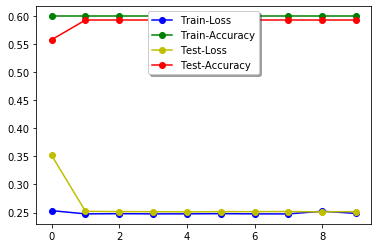

In [ ]:
plt.plot(list(results.history.values())[0],'b-o',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g-o',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)
plt.plot(list(results.history.values())[2],'y-o',label='Test-Loss')
plt.plot(list(results.history.values())[3],'r-o',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

CapsNet + Image + Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(trainX)

    # Fit the model on the batches generated by datagen.flow().
results = model.fit_generator(
        datagen.flow(trainX, trainY, batch_size=batch_size),
        epochs=epochs,
        validation_data=(testX, testY),
        workers=4)


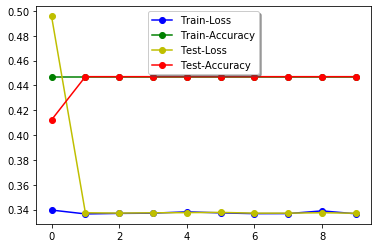

In [ ]:
plt.plot(list(results.history.values())[0],'b-o',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g-o',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)
plt.plot(list(results.history.values())[2],'y-o',label='Test-Loss')
plt.plot(list(results.history.values())[3],'r-o',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

## Image+Text


In [ ]:
#text data
X_text.shape

(6988, 192)

In [ ]:
#image data
X.shape, Y.shape

((6988, 128, 128, 3), (6988, 3))

In [ ]:

class_weights

{0: 3.6914949815108296, 1: 1.058306830228684, 2: 0.560474815527751}

#### Model 4 - Concat CNN+LSTM

In [ ]:
np.random.seed(1)
set_seed(2)
a = input_text = Input(shape = max_length)
a = Embedding(vocab_size, 100)(a)
# b = Dropout(0.2)(b)

a = LSTM(128, return_sequences=True)(a)  # Activation 是否需要？？？
# b = Dropout(0.2)(b)

# a = LSTM(128)(a)
a = Flatten()(a)
a = Dense(3, activation='relu')(a)

# output = Dense(5, activation='softmax')(a)
# Model_text_clr = Model(input_text,output)
# Model_text_clr.compile(loss = "categorical_crossentropy",  #sparse_categorical_crossentropy,optimizer = 'adam',metrics = ['accuracy'])
# Model_text_clr.summary()

In [ ]:
b = input_img = Input(shape = (width, height, channels))
b = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform')(b)
b = Dropout(0.2)(b)
b = MaxPooling2D((2,2))(b)
b = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform')(b)
b = MaxPooling2D((2,2))(b)
b = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform')(b)
b = MaxPooling2D((2,2))(b)
b = Flatten()(b)
b = Dense(128, activation='relu')(b)
# output = Dense(5, activation='softmax')(b)
# Model_img_clr = Model(input_img,output)
# Model_img_clr.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [ ]:
combine = Concatenate(axis=-1,)([a,b])
combine = Dense(128, activation='relu')(combine)
# combine = Dropout(0.2)(combine)
# combine = Dense(32, activation='relu')(combine)
# combine = Dropout(0.2)(combine)
output = Dense(3, activation='softmax')(combine)

Model_text_img_clr = Model([input_img,input_text],output)
Model_text_img_clr.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
Model_text_img_clr.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
plot_model(Model_text_img_clr, to_file='model4.png')

In [ ]:
results = Model_text_img_clr.fit([X,X_text], Y,
         epochs=20, #14 0.5122
         batch_size=128,
         shuffle=True,
        validation_split=0.2,
         class_weight=class_weights
         )

Epoch 1/20
44/44 [==============================] - 11s 257ms/step - loss: 2.3707 - accuracy: 0.3177 - val_loss: 1.1013 - val_accuracy: 0.3104
Epoch 2/20
44/44 [==============================] - 9s 214ms/step - loss: 1.1017 - accuracy: 0.3197 - val_loss: 1.1133 - val_accuracy: 0.1810
Epoch 3/20
44/44 [==============================] - 9s 215ms/step - loss: 1.0695 - accuracy: 0.3633 - val_loss: 1.1274 - val_accuracy: 0.2189
Epoch 4/20
44/44 [==============================] - 9s 215ms/step - loss: 0.9852 - accuracy: 0.4322 - val_loss: 1.0981 - val_accuracy: 0.3755
Epoch 5/20
44/44 [==============================] - 9s 215ms/step - loss: 0.8432 - accuracy: 0.5342 - val_loss: 1.1662 - val_accuracy: 0.3598
Epoch 6/20
44/44 [==============================] - 9s 215ms/step - loss: 0.6692 - accuracy: 0.6383 - val_loss: 1.1732 - val_accuracy: 0.4506
Epoch 7/20
44/44 [==============================] - 10s 221ms/step - loss: 0.4795 - accuracy: 0.7578 - val_loss: 1.3192 - val_accuracy: 0.4614
Epoc

In [ ]:
Model_text_img_clr.evaluate([X_trial,X_text_trial], Y_trial)

29/29 [==============================] - 1s 30ms/step - loss: 1.2484 - accuracy: 0.7978


[1.2483749389648438, 0.797802209854126]

In [ ]:
temp = Model_text_img_clr.predict([X_trial,X_text_trial])
temp_pre = [np.argmax(i) for i in temp]
temp_truth = [np.argmax(i) for i in Y_trial]
print(accuracy_score(temp_pre, temp_truth),f1_score(temp_pre, temp_truth, average='macro'))

0.7978021978021979 0.7395497036582755


In [ ]:
print(f1_score(temp_pre, temp_truth, average='micro'))

0.7978021978021979


In [ ]:
print(f1_score(temp_pre, temp_truth, average='weighted'))

0.7998273691683095


In [ ]:
print(classification_report(temp_pre, temp_truth))

              precision    recall  f1-score   support

           0       0.65      0.64      0.64        72
           1       0.68      0.77      0.72       248
           2       0.87      0.83      0.85       590

    accuracy                           0.80       910
   macro avg       0.74      0.75      0.74       910
weighted avg       0.80      0.80      0.80       910



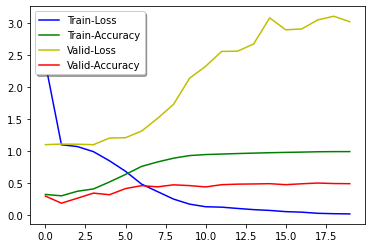

In [ ]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.plot(list(results.history.values())[2],'y',label='Valid-Loss')
plt.plot(list(results.history.values())[3],'r',label='Valid-Accuracy')
plt.legend(loc='upper left', shadow=True)

In [ ]:
# Model_text_img_clr.evaluate()

Output Model

In [ ]:
pwd

'/content/drive/My Drive/SemEval_2020'

In [ ]:
Model_text_img_clr.save('./models/Model_img_text_0.74.model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/Model_img_text_0.74.model/assets


### Model 6 - CapsNet+Text+Img

In [ ]:
num_class = 5

t = input_text = Input(shape = (max_length,))
t = Embedding(vocab_size, 50)(t)
t = Dropout(0.2)(t)
t = CuDNNLSTM(64, return_sequences=True)(t)
t = Flatten()(t)

# t = Conv1D(128, 3, padding='valid', activation='relu', strides=1)(t)
# t = GlobalMaxPooling1D()(t)
# t = Dense(128, activation='relu')(t)

x = input_image = Input(shape=(width, height, channels))
t = Dropout(0.2)(t)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = AveragePooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Flatten()(x)

combine = Concatenate(axis=-1,)([t,x])
combine = Dense(128, activation='relu')(combine)
combine = Reshape((-1, 64))(combine)

capsule = Capsule(num_class, 16, 3, True)(combine)

output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)

Model6 = Model([input_text,input_image], output)
Model6.compile(loss=margin_loss, optimizer='adam', metrics=['accuracy'])
Model6.summary()

NameError: ignored

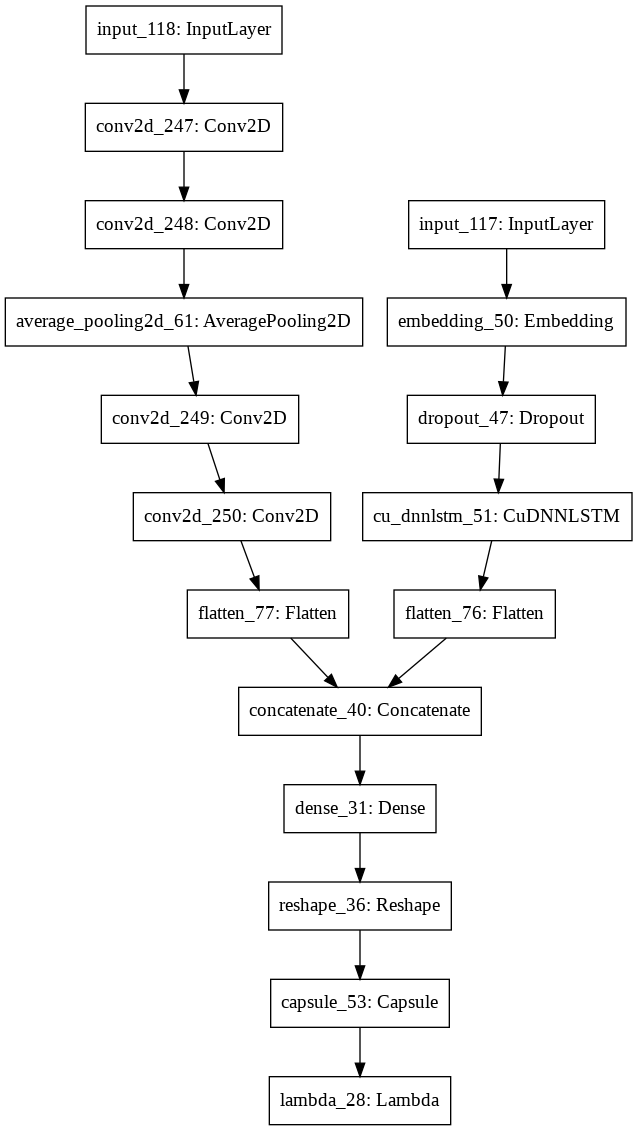

In [ ]:
plot_model(Model6, to_file='model6.png')

In [ ]:
results = Model6.fit(
        [padded_train,X],
        Y,
        batch_size=64,
        epochs=10,
        validation_split=0.2,
#         validation_data=(testX, testY),
        shuffle=True,
#         class_weight=class_weights
)

NameError: ignored

### Task-B

#### Single classification

In [ ]:
data.head(1)

,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,very_positive


In [ ]:
data['sarcasm'].value_counts()

general            3505
twisted_meaning    1545
not_sarcastic      1544
very_twisted        394
Name: sarcasm, dtype: int64

In [ ]:
data_test.head()

,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment,s,h,o,m
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,very_positive,1,0,0,0
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive,1,1,0,1
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive,0,1,0,0
3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive,1,1,1,1
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral,1,0,1,0


In [ ]:
# Y_s = data['sarcasm']
# Y_s = data['humour']
# Y_s = data['offensive']
# Y_s = data['motivational']

# # 0 - no label, 1 - lanel exists
# data['s'] = list(pd.Series(data['sarcasm'].factorize()[0]).replace([0,2,3],'1').replace(1,0).replace('1',1)) #['general', 'not_sarcastic', 'twisted_meaning', 'very_twisted']
# data['h'] = list(pd.Series(data['humour'].factorize()[0]).replace([1,2,3],1)) #['not_funny', 'very_funny', 'hilarious', 'funny']
# data['o'] = list(pd.Series(data['offensive'].factorize()[0]).replace([1,2,3],1)) #['not_offensive', 'very_offensive', 'slight', 'hateful_offensive']
# data['m'] = list(pd.Series(data['motivational'].factorize()[0])) #['not_motivational', 'motivational']

# data_train = data
Y_s = data_train['m']
# use classes weights to handle data imbalance
from sklearn.utils import class_weight
class_weights_s = class_weight.compute_class_weight('balanced',np.unique(Y_s),Y_s)
# Y_s = to_categorical(Y_s)
class_weights_s

array([0.77266696, 1.41686942])

In [ ]:
model = Sequential()
model.add(Conv2D(32, (2, 2), padding='same', activation='relu', input_shape=(width, height, channels)))
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))

model.add(Conv2D(64, (2, 2), activation='relu',padding='same'))
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()

In [ ]:
es = callbacks.EarlyStopping(monitor='acc', mode='max')

# fit model with generator
results = model.fit(X, Y_s,
         epochs=3,
         batch_size=64,
         shuffle=True,
        validation_split=0.2,
        #  callbacks=[es],
         class_weight=class_weights_s      
         )

Train on 5590 samples, validate on 1398 samples
Epoch 1/3
5590/5590 [==============================] - 6s 1ms/sample - loss: 0.1686 - acc: 0.9426 - val_loss: 1.2378 - val_acc: 0.5780
Epoch 2/3
5590/5590 [==============================] - 6s 1ms/sample - loss: 0.0949 - acc: 0.9737 - val_loss: 1.4431 - val_acc: 0.5694
Epoch 3/3
5590/5590 [==============================] - 6s 1ms/sample - loss: 0.0762 - acc: 0.9834 - val_loss: 1.6424 - val_acc: 0.5758


In [ ]:
a = input_text = Input(shape = 192)
a = Embedding(vocab_size, 100)(a)
a = CuDNNLSTM(128, return_sequences=True)(a)
a = CuDNNLSTM(128)(a)
a = Flatten()(a)
a = Dense(128, activation='relu')(a)

b = input_img = Input(shape = (width, height, channels))
b = Conv2D(32, (3, 3), activation='relu')(b)
b = MaxPooling2D((2,2))(b)
b = Conv2D(64, (3, 3), activation='relu')(b)
b = MaxPooling2D((2,2))(b)
b = Flatten()(b)
b = Dense(128, activation='relu')(b)

combine = Concatenate(axis=-1,)([a,b])
# combine = Dense(64, activation='relu')(combine)
combine = Dropout(0.2)(combine)
# combine = Dense(32, activation='relu')(combine)
# combine = Dropout(0.2)(combine)
output = Dense(1, activation='s')(combine)
Model_text_img_clr = Model([input_text,input_img],output)
Model_text_img_clr.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Model_text_img_clr.summary()

In [ ]:

es = callbacks.EarlyStopping(monitor='acc', mode='max')

results = Model_text_img_clr.fit([padded_train,X], Y_s,
         epochs=10,
         batch_size=64,
         shuffle=True,
        validation_split=0.2,
        # callbacks=[es],
        #  class_weight=class_weights_s      
)

#### Multi-label classification

In [ ]:
# 0 - no label, 1 - lanel exists
data['s'] = list(pd.Series(data['sarcasm'].factorize()[0]).replace([0,2,3],'1').replace(1,0).replace('1',1)) #['general', 'not_sarcastic', 'twisted_meaning', 'very_twisted']
data['h'] = list(pd.Series(data['humour'].factorize()[0]).replace([1,2,3],1)) #['not_funny', 'very_funny', 'hilarious', 'funny']
data['o'] = list(pd.Series(data['offensive'].factorize()[0]).replace([1,2,3],1)) #['not_offensive', 'very_offensive', 'slight', 'hateful_offensive']


In [ ]:
s_h_o = []
for i in data.index:
  concat =  ''.join([str(data['s'][i]),str(data['h'][i]),str(data['o'][i])])
#   concat =  [data['s'][i],data['h'][i],data['o'][i]]
  s_h_o.append(concat)
data['s_h_o']=s_h_o

In [ ]:
Y_sho = data['s_h_o'].factorize()[0]
# use classes weights to handle data imbalance
from sklearn.utils import class_weight
class_weights_s = class_weight.compute_class_weight('balanced',np.unique(Y_sho),Y_sho)
Y_sho = to_categorical(Y_sho)
class_weights_s

array([ 6.51865672,  0.62571633,  0.79698905,  0.24808293,  2.22264631,
        2.69598765, 10.27647059, 22.3974359 ])

In [ ]:

a = input_text = Input(shape = max_length)
a = Embedding(vocab_size, 100)(a)
a = CuDNNLSTM(128, return_sequences=True)(a)
a = CuDNNLSTM(128)(a)
a = Flatten()(a)
a = Dense(128, activation='relu')(a)

b = input_img = Input(shape = (width, height, channels))
b = Conv2D(32, (3, 3), activation='relu')(b)
b = MaxPooling2D((2,2))(b)
b = Conv2D(64, (3, 3), activation='relu')(b)
b = MaxPooling2D((2,2))(b)
b = Flatten()(b)
b = Dense(128, activation='relu')(b)

combine = Concatenate(axis=-1,)([a,b])
# combine = Dense(64, activation='relu')(combine)
combine = Dropout(0.2)(combine)
# combine = Dense(32, activation='relu')(combine)
# combine = Dropout(0.2)(combine)
output = Dense(8, activation='softmax')(combine)
Model_text_img_clr = Model([input_text,input_img],output)
Model_text_img_clr.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Model_text_img_clr.summary()

es = callbacks.EarlyStopping(monitor='acc', mode='max')

results = Model_text_img_clr.fit([padded_train,X], Y_sho,
         epochs=15,
         batch_size=64,
         shuffle=True,
        validation_split=0.2,
        callbacks=[es],
         class_weight=class_weights_s      
)

Train on 5590 samples, validate on 1398 samples
Epoch 1/15
5590/5590 [==============================] - 6s 1ms/sample - loss: 1.7231 - acc: 0.4841 - val_loss: 1.4468 - val_acc: 0.4943
Epoch 2/15
5590/5590 [==============================] - 5s 983us/sample - loss: 1.4187 - acc: 0.5061 - val_loss: 1.4465 - val_acc: 0.4943
Epoch 3/15
5590/5590 [==============================] - 5s 978us/sample - loss: 1.3645 - acc: 0.5098 - val_loss: 1.4859 - val_acc: 0.4921
Epoch 4/15
5590/5590 [==============================] - 5s 979us/sample - loss: 1.2334 - acc: 0.5447 - val_loss: 1.5321 - val_acc: 0.4707
Epoch 5/15
5590/5590 [==============================] - 5s 981us/sample - loss: 1.0307 - acc: 0.6202 - val_loss: 1.7707 - val_acc: 0.4206
Epoch 6/15
5590/5590 [==============================] - 6s 991us/sample - loss: 0.7803 - acc: 0.7125 - val_loss: 2.1182 - val_acc: 0.4120
Epoch 7/15
5590/5590 [==============================] - 6s 989us/sample - loss: 0.5531 - acc: 0.7953 - val_loss: 2.6695 - val_

# Manual Test

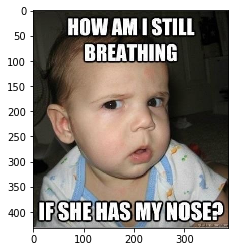

In [ ]:
test_img = cv2.cvtColor(cv2.imread(PATH_IMG+data['Image_name'][1]), cv2.COLOR_BGR2RGB)
plt.imshow(test_img)

In [ ]:
data[:5]

,Image_name,OCR_extracted_text,Overall_Sentiment
0,10_year_10-year-challenge_1547788782.jpeg,The best of #10 YearChallenge! Completed in le...,very_positive
1,10_year_10yearchallenge-5c75f8b946e0fb0001edc7...,Sam Thorne @Strippin ( Follow Follow Saw every...,positive
2,10_year_10-year-challenge-sweet-dee-edition-40...,10 Year Challenge - Sweet Dee Edition,positive
3,10_year_10-year-challenge-with-no-filter-47-hi...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,neutral
4,10_year_10-years-challenge-about-humanity_o_72...,"1998: ""Don't get in car with strangers"" 2008: ...",negative


In [ ]:
#prediction
temp = model.predict(X_text_trial)
temp_pre = [np.argmax(i) for i in temp]
# temp_pre

In [ ]:
#Ground Truth
temp = Y_trial
temp_truth = [np.argmax(i) for i in temp]
# temp_truth

In [ ]:
print(accuracy_score(temp_pre, temp_truth),
f1_score(temp_pre, temp_truth, average='macro'))

0.5684093437152391 0.32123071410253085


In [ ]:
model.evaluate(X[800:813],Y[800:813])

13/13 [==============================] - 0s 573us/sample - loss: 1.4527 - acc: 0.7538


[1.4527454376220703, 0.75384617]

## Result Analysis

In [ ]:
def resultAnalysis(model, data_x, data_y):
  y_pred = model.predict(testX)
  y_pred_cate = [np.argmax(i) for i in y_pred]
  print("Prediction classes count:\n",pd.Series(y_pred_cate).value_counts())
  y_truth = [np.argmax(i) for i in testY]
  print("\nTest classes count:\n",pd.Series(y_truth).value_counts())
  print(classification_report(y_truth,y_pred_cate))

In [ ]:
resultAnalysis(model, testX, testY)

# Load model and test data



In [ ]:
import pickle 
X_test = pickle.load(open("/content/drive/My Drive/SemEval_2020/TestX.pickle", "rb"))
data_test = pickle.load(open("/content/drive/My Drive/SemEval_2020/TestData.pickle", "rb"))
# X = X/255

In [ ]:
data_test.shape, X_test.shape,X_test.min(),X_test.max()

((1878, 4), (1877, 128, 128, 3), 0, 255)

In [ ]:
data_test.head(2)

,Image_name,Image_URL,OCR_extracted_text,corrected_text
0,chuck_chuck_norris_meme_10.jpg,https://gtmemes.com/wp-content/uploads/2019/03...,Some magicians can walk on water Chuck Norris...,Some magicians can walk on water Chuck Norris...
1,dr_evil_NDBB96K.png,https://i.imgur.com/NDBB96K.png,ONE MILLION DOLLARS made on imgur,ONE MILLION DOLLARS made on imgur


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
t = Tokenizer()
X_text = data['corrected_text']
X_text = [str(i) for i in X_text]
t.fit_on_texts(X_text)
vocab_size = len(t.word_index) + 1
print (vocab_size)
encoded_train = t.texts_to_sequences(X_text)
# max_length = max(list(map(lambda x: len(x), encoded_train)))
padded_train = pad_sequences(encoded_train, maxlen=192, padding='post')

6055


In [ ]:
# from tensorflow.keras import models
# model = models.load_model('/content/drive/My Drive/SemEval_2020/models/Model_4_img_text.h5')

In [ ]:
Model_text_img_clr.summary()

In [ ]:
padded_train.shape, X.shape

((1878, 192), (1877, 128, 128, 3))

In [ ]:
prediction = Model_text_img_clr.predict([padded_train[1:],X])
prediction.shape

(1877, 3)

## Save test results

In [ ]:
# my_model = tf.keras.models.load_model('/content/drive/My Drive/SemEval_2020/models/Model_img_text_0.74.model')


In [ ]:
prediction = model.predict(X_test)

In [ ]:
temp_pre = [np.argmax(i) for i in prediction]
pd.Series(temp_pre).value_counts()

2    1213
1     545
0     119
dtype: int64

rray(['negative', 'neutral', 'positive'], dtype=object)

In [ ]:
temp_pre.insert(0,0)
len(temp_pre)

1878

In [ ]:
temp_pre = pd.Series(temp_pre).replace(0,-1).replace(1,0).replace(2,1)
temp_pre.value_counts()


 1    1213
 0     545
-1     120
dtype: int64

save as csv


In [ ]:
res = pd.DataFrame(temp_pre)
# res[1] = [9999 for i in range(len(res))]
# res[2] = [9999 for i in range(len(res))]
# res = res.replace(2,-1).replace(0,'p').replace(1,0).replace('p',1)
res[0].value_counts()

 1    1213
 0     545
-1     120
Name: 0, dtype: int64

In [ ]:
res.shape

res.to_csv('./New_Training_Data/task8A_siyuan20.csv',header=False,index=False,sep=',')


In [ ]:
pwd

'/content'

In [ ]:
res = Model_text_img_clr.predict([padded_train[1:],X])


In [ ]:
res.shape

(1877, 8)